In [6]:
# This project is intended to perform a Sentimental Analysis on the Amazon Reviews
# We will be applying the LSTM model on the Amazon reviews to predict the Review Ratings


# We will start by importing all the librabries we need for performing LSTM operation 
# on a Text Review from Amazon and will try find out the negative & positive feedback from those reviews

import numpy as np 
import pandas as pd 
import os
import nltk
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
import string
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
# import pdb; pdb.set_trace() 
import re
import gradio as gr
%matplotlib inline

In [7]:
# Here we are reading a CSV file using pandas and converting to DataFramce , as the data is already in a row/col format 
# no extra effort required here. 

data = pd.read_excel('../review-details.xlsx')

In [8]:
# in this step we will get rid of all the NAN values across the column for individual rows

data.dropna(axis = 1, how ='any').head()

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,manufacturer,market,review_type,parent_review,dimension1,dimension2,dimension8,verified_purchase,helpful_review_count,review_hash_id
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,Unilever Global,UK,Organic,Child,Deos,Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,Unilever Global,UK,Organic,Child,Savoury,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,Unilever Global,UK,Organic,Child,Savoury,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,Unilever Global,UK,Organic,Parent,Savoury,Beef Stock/Pots/Cubes/Extract/Liquid/Concentrated,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,Unilever Global,UK,Organic,Parent,HHC,Bathroom Mousse,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae


C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\2585619436.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=data, palette='hls')


<Axes: xlabel='category', ylabel='count'>

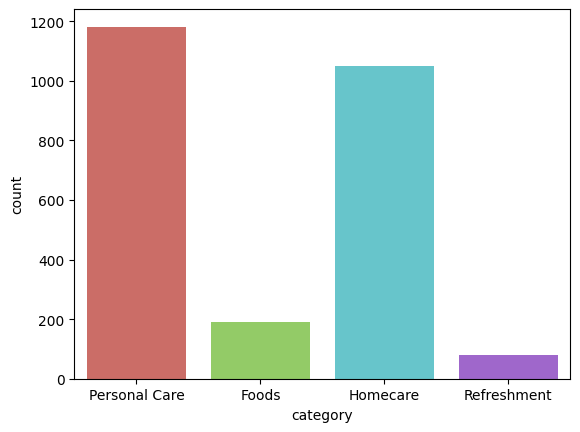

In [9]:
# Lets now get a count of products Amazon is trying to see and get a plot of the count 

sns.countplot(x='category', data=data, palette='hls')

In [10]:
# As the category data is in a lablled format,
# we get a number for each of these different lables by using the Label Encoding method

lb_make = LabelEncoder()
data['category_new'] = lb_make.fit_transform(data['category'])
data[['category_new', 'category']].head()

,category_new,category
0,2,Personal Care
1,0,Foods
2,0,Foods
3,0,Foods
4,1,Homecare


<Axes: xlabel='review_rating_label', ylabel='count'>

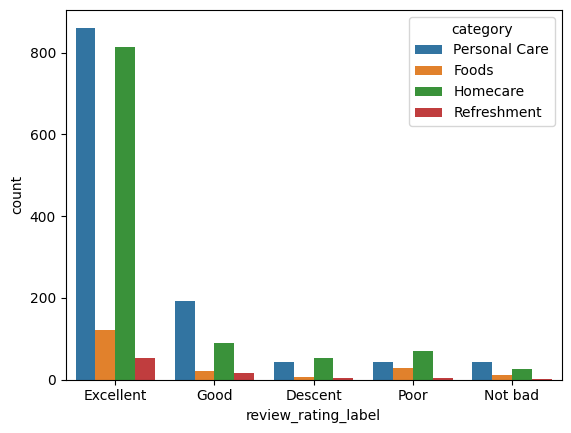

In [11]:
# In this step will get a plot of review_rating across different products ,
# This is a good practice to understand how satisfied the customers are with the products they are purchasing online 

mapping = {1: 'Poor', 2: 'Not bad', 3: 'Descent', 4: 'Good', 5: 'Excellent'}

data['review_rating_label'] = data['review_rating'].map(mapping)

sns.countplot(x='review_rating_label', hue='category', data= data)

C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\27166401.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['review_rating'])


<Axes: xlabel='review_rating', ylabel='Density'>

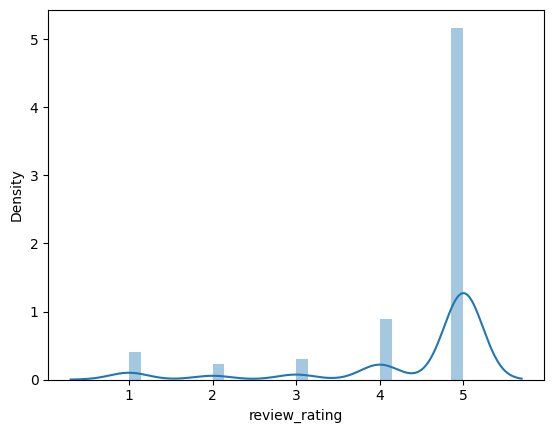

In [12]:
# Lets take a quick peak at the distribution of review_rating
# that will help us decide to get rid of neutral feedbacks
# will try to keep the feedback between Positive and Negatve Reviews

sns.distplot(data['review_rating'])

In [13]:
# Lets display the first 5 rows of our data frame 

data.head(5)

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,dimension4,dimension5,dimension6,dimension7,dimension8,verified_purchase,helpful_review_count,review_hash_id,category_new,review_rating_label
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,NaN,NaN,NaN,COTC Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f,2,Excellent
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315,0,Excellent
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7,0,Good
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,NaN,NaN,NaN,Stock Pots,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0,0,Excellent
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,NaN,NaN,NaN,NaN,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae,1,Excellent


In [14]:
# Now we have arrived at one of most important step , which is feature extraction,
# I think you should play with less and most significant feature at a time and start adding more features
# if you have solid understanding of the industry from where the problem statement is coming from.
# As the whole purpose of this program is Sentimental Analysis on the reviews , am choosing only 2 features as 
# shown below. 

train_data = data[['review_text','review_rating']]

train_data.head()

,review_text,review_rating
0,"As you get older, you know what you like and w...",5
1,Three gigantic marmite jars that will last pro...,5
2,Excellent,4
3,A great flavour top - up for slow cooking.,5
4,Does what is says it does,5


In [15]:
# Data cleaning is vital when it comes to NLP application on the text data

def rem_punctuation(text):
    no_punc = "".join([ x for x in text if x not in string.punctuation])
    return no_punc

In [16]:
# Lets remove all the punctuations from our review_text data

train_data['review_text'] = train_data['review_text'].apply(lambda x: rem_punctuation(x))
train_data['review_text'].head()

C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\756837138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['review_text'] = train_data['review_text'].apply(lambda x: rem_punctuation(x))


0    As you get older you know what you like and wh...
1    Three gigantic marmite jars that will last pro...
2                                            Excellent
3             A great flavour top  up for slow cooking
4                            Does what is says it does
Name: review_text, dtype: object

In [17]:
# Let's convert the words in the reviews to tokens from our review_text data
# As a first step , create an instance of the Tokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [18]:
# Let's apply the tokenizer on our review text data

train_data['review_text']  = train_data['review_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
train_data['review_text'].head()

C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\561339763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['review_text']  = train_data['review_text'].apply(lambda x: tokenizer.tokenize(x.lower()))


0    [as, you, get, older, you, know, what, you, li...
1    [three, gigantic, marmite, jars, that, will, l...
2                                          [excellent]
3     [a, great, flavour, top, up, for, slow, cooking]
4                     [does, what, is, says, it, does]
Name: review_text, dtype: object

In [19]:
def rem_stopwords(text):
    words = [w for w in text if w in stopwords.words('english')]
    return words

In [20]:
# We need a lemmatizer on our review_text ,Lemmatization  brings context to the words. 
# So it links words with similar meaning to one word. Let see how that helps our model 

lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [21]:
# lets apply the lemmatization function

train_data['review_text']  = train_data['review_text'].apply(lambda x: word_lemmatizer(x))
train_data['review_text'].head()

C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\624289330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['review_text']  = train_data['review_text'].apply(lambda x: word_lemmatizer(x))


0    [a, you, get, older, you, know, what, you, lik...
1    [three, gigantic, marmite, jar, that, will, la...
2                                          [excellent]
3     [a, great, flavour, top, up, for, slow, cooking]
4                        [doe, what, is, say, it, doe]
Name: review_text, dtype: object

In [22]:
# In this step we would like to conclude the review_rating around Postitive=1 and negative=0 values
# We will use these as a classification for our 'review_texts' , more like a feedback from customer !!

train_data.dropna(inplace=True)
train_data[train_data['review_rating'] != 3]
train_data['Positivity'] = np.where(train_data['review_rating'] > 3, 1, 0)
cols = ['review_rating']
train_data.drop(cols, axis=1, inplace=True)
train_data.head()

C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\322065916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(inplace=True)
C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\322065916.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Positivity'] = np.where(train_data['review_rating'] > 3, 1, 0)
C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\322065916.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,review_text,Positivity
0,"[a, you, get, older, you, know, what, you, lik...",1
1,"[three, gigantic, marmite, jar, that, will, la...",1
2,[excellent],1
3,"[a, great, flavour, top, up, for, slow, cooking]",1
4,"[doe, what, is, say, it, doe]",1


In [23]:
# Just getting a count of Positive and Negative counts
# train_data.groupby('Positivity').size()

# sns.countplot(x='Positivity', data = train_data, palette = 'hls')

In [24]:
# By now we have are finished with pre-processing our text_review column 
# So lets go ahead and extract the X = features and Y target label

X = train_data['review_text']
Y = train_data['Positivity']

train_data['review_text']=[" ".join(review) for review in train_data['review_text'].values]
train_data['review_text'].head()

C:\Users\kudnaver\AppData\Local\Temp\ipykernel_29868\3423741976.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['review_text']=[" ".join(review) for review in train_data['review_text'].values]


0    a you get older you know what you like and wha...
1    three gigantic marmite jar that will last prob...
2                                            excellent
3              a great flavour top up for slow cooking
4                               doe what is say it doe
Name: review_text, dtype: object

In [25]:
# Here we are splitting the X & Y data with a test size = 20 % 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [26]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

In [27]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2000,) (2000,)
(501,) (501,)


In [28]:
# This step is to check the ratio of positive to negatives values in our Test and Train Dataset

print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[Y_train == 0]) / (len(X_train)*1.))*100,
                                                                        (len(X_train[Y_train == 1]) / (len(X_train)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[Y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[Y_test == 1]) / (len(X_test)*1.))*100))

Train set has total 2000 entries with 13.35% negative, 86.65% positive
Test set has total 501 entries with 13.37% negative, 86.63% positive


In [29]:
# Now it is equally important to check how balanced our Classfication data is w.r.t Positive and Negative rating 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [30]:
# # As i was mentioning earlier that choosing the correct number of features plays a vital role in creating a model for 
# # an accurate predictions ,it is a good practice to check the number of features having an impact on 
# # our accuracy score, so we will take advantage of Random Forest to be able to achieve that, so lets begin !!

# cv = CountVectorizer()
# rf = RandomForestClassifier(class_weight="balanced")
# n_features = np.arange(10000,25001,5000)

# def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
#     result = []
#     print(classifier)
#     print("\n")
#     for n in n_features:
#         vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
#         checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
#         print("Test result for {} features".format(n))
#         nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, Y_train, X_test, Y_test)
#         result.append((n,nfeature_accuracy))
#     return result
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer()
# print("Result for trigram with stop words (Tfidf)\n")
# feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 4))

In [31]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,25001,5000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        # Ensure that stop_words is a list or None, not a list of lists
        if isinstance(stop_words, list):
            # You can print the stop_words list here for debugging if needed
            print("Using custom stop words:", stop_words)
        
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, Y_train, X_test, Y_test)
        result.append((n, nfeature_accuracy))
    return result


In [32]:
print(X_train.dtype)

object


In [33]:
print(set(X_train))

{"['fab', 'stocking', 'filler']", "['but', 'thats', 'personal', 'taste', 'sold', 'mine', 'on']", "['i', 'bought', 'this', 'two', 'week', 'ago', 'and', 'i', 'am', 'very', 'pleased', 'with', 'it', 'i', 'have', 'been', 'using', 'simple', 'product', 'for', 'many', 'many', 'year', 'and', 'i', 'wouldnt', 'changeover', 'the', 'year', 'i', 'have', 'tried', 'different', 'make', 'but', 'none', 'suit', 'me', 'a', 'much', 'a', 'simplethe', 'eco', 'friendly', 'parcel', 'arrived', 'on', 'time']", "['really', 'good', 'value']", "['delivered', 'quickly', 'and', 'decent', 'shampoo', 'only', '4', 'star', 'a', 'one', 'bottle', 'wa', 'leaking', 'when', 'delivered']", "['smell', 'lovely', 'and', 'fresh']", "['i', 'love', 'this', 'body', 'wash', 'because', 'it', 'ha', 'such', 'a', 'subtle', 'comforting', 'aroma', 'and', 'it', 'go', 'so', 'smoothly', 'on', 'the', 'skin', 'i', 'feel', 'like', 'i', 'dont', 'have', 'to', 'drench', 'my', 'skin', 'in', 'lotion', 'when', 'i', 'get', 'out', 'on', 'the', 'other', 'h

In [34]:
print("Unique values in Y_train:", set(Y_train))
print("Unique values in Y_test:", set(Y_test))

Unique values in Y_train: {0, 1}
Unique values in Y_test: {0, 1}


In [35]:
# label_mapping = {'negative': 0, 'positive': 1}
# Y_train = Y_train.map(label_mapping)
# Y_test = Y_test.map(label_mapping)

In [36]:
# # In this step we are checking the classification report across negative and positive rating 

# from sklearn.metrics import classification_report
# cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
# pipeline = Pipeline([('vectorizer', cv),('classifier', rf)])
# sentiment_fit = pipeline.fit(X_train, Y_train)
# y_pred = sentiment_fit.predict(X_test)
# print(classification_report(Y_test, y_pred, target_names=['negative','positive']))
# # print(cv.get_feature_names())

In [37]:
# import numpy as np

# Check for NaN values in Y_train and Y_test
print("NaN values in Y_train:", np.isnan(Y_train).sum())
print("NaN values in Y_test:", np.isnan(Y_test).sum())


NaN values in Y_train: 0
NaN values in Y_test: 0


In [38]:
# # Remove rows with NaN values in Y_train or Y_test
# X_train = X_train[~np.isnan(Y_train)]
# Y_train = Y_train[~np.isnan(Y_train)]

# X_test = X_test[~np.isnan(Y_test)]
# Y_test = Y_test[~np.isnan(Y_test)]


In [39]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2000,) (2000,)
(501,) (501,)


In [40]:
# Example of how you set your model up
cv = CountVectorizer(max_features=30000, ngram_range=(1, 3))
rf = RandomForestClassifier(class_weight="balanced")

# Create the pipeline
pipeline = Pipeline([('vectorizer', cv), ('classifier', rf)])

# Fit the model
sentiment_fit = pipeline.fit(X_train, Y_train)

# Predict on test data
y_pred = sentiment_fit.predict(X_test)

# Check the unique values in Y_test to confirm they are 0s and 1s
print("Unique values in Y_test:", set(Y_test))

# Generate classification report
print(classification_report(Y_test, y_pred, target_names=['negative', 'positive']))


Unique values in Y_test: {0, 1}
              precision    recall  f1-score   support

    negative       1.00      0.40      0.57        67
    positive       0.92      1.00      0.96       434

    accuracy                           0.92       501
   macro avg       0.96      0.70      0.77       501
weighted avg       0.93      0.92      0.90       501



In [41]:
# train_data['review_text'][0]
train_data['Positivity'].nunique()

2

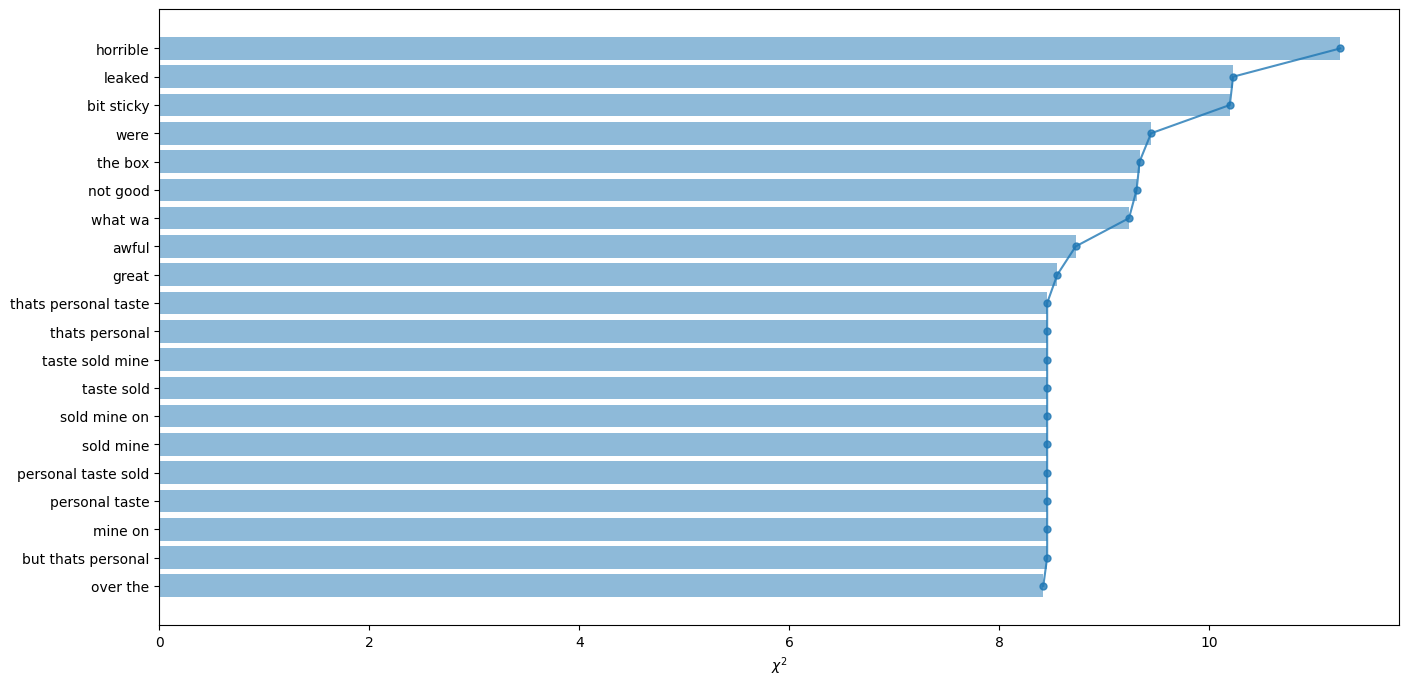

In [42]:
# Well a chi2 score is always benefinicial to learn the words having less dependencies for hypothesis
# and thus can be ignored during the feature selection process, the primary reason for using chi2 sqaure method.

from sklearn.feature_selection import chi2
tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(train_data['review_text'])
y = train_data['Positivity']
chi2score = chi2(X_tfidf, y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names_out(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [43]:
# We need a final pre-paration before we input it to our LSTM Model, which is the next step
# we start with setting to text to sequence and pad the sequence for an equal lenght of input data to be fed
# to our LSTM model. 

MAX_NB_WORDS = 50000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['review_text'].values)

X1 = tokenizer.texts_to_sequences(train_data['review_text'].values)
X1 = pad_sequences(X1)
Y1 = pd.get_dummies(train_data['Positivity']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)
# print(Y1)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(X1.shape[1])
X1

(1875, 278) (1875, 2)
(626, 278) (626, 2)
Found 3889 unique tokens.
278


array([[  0,   0,   0, ...,  12,  51, 951],
       [  0,   0,   0, ..., 121,  24,   6],
       [  0,   0,   0, ...,   0,   0, 180],
       ...,
       [  0,   0,   0, ...,   9,   2,  79],
       [  0,   0,   0, ...,  40,  37, 655],
       [  0,   0,   0, ...,  20, 399, 121]])

In [44]:
# Finally we have arrived at designing our LSTM model

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 278
# This is fixed.
EMBEDDING_DIM = 150
lstm_out = 200
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

d:\anaconda3\envs\torch_env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
# At this step we set few parameters based our own experience which will come to you overtime.
# So basically we setting a batch size for our input data and epoch= for number of iterations our model
# has to go through !!!

batch_size = 32
history = model.fit(X1_train, Y1_train, epochs = 5, batch_size=batch_size, verbose = 2)

Epoch 1/5
59/59 - 42s - 718ms/step - accuracy: 0.8635 - loss: 0.4100
Epoch 2/5
59/59 - 32s - 535ms/step - accuracy: 0.8885 - loss: 0.3018
Epoch 3/5
59/59 - 28s - 478ms/step - accuracy: 0.9344 - loss: 0.1985
Epoch 4/5
59/59 - 26s - 434ms/step - accuracy: 0.9563 - loss: 0.1373
Epoch 5/5
59/59 - 29s - 485ms/step - accuracy: 0.9696 - loss: 0.0960


In [46]:
accuracy = model.evaluate(X1_test, Y1_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9157 - loss: 0.2575
Test set
  Loss: 0.277
  Accuracy: 0.914


In [47]:
# from keras.callbacks import History 
# history = History()
# history.model
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


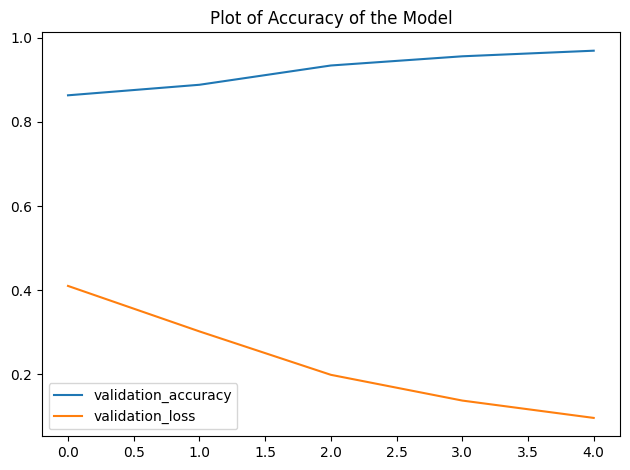

In [48]:
# Finally, we can see that the validation loss and validation accuracy both are in sync with the training loss and 
# accuracy .Even though the validation loss and accuracy line are not linear, but it shows that your model is not 
# overfitting: the validation loss is decreasing and not increasing, and there is not much gap between training 
# and validation accuracy.

plt.title('Plot of Accuracy of the Model')
plt.plot(history.history['accuracy'], label='validation_accuracy')
plt.plot(history.history['loss'], label='validation_loss')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# Lets find the percentage of Positive & Negative reviews with our existing LSTM model . 

pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X1_test)):
    
    result = model.predict(X1_test[x].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 2)
   
    if np.argmax(result) == np.argmax(Y1_test[x]):
        if np.argmax(Y1_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y1_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

predicted_classes = model.predict(X1_test)
# predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
# predicted_classes.shape, X1_test.shape
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")
# pos_acc 90.67439409905164 %
# neg_acc 63.2890365448505 %

1/1 - 0s - 381ms/step
1/1 - 0s - 81ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 81ms/step
1/1 - 0s - 82ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 74ms/step
1/1 - 0s - 82ms/step
1/1 - 0s - 82ms/step
1/1 - 0s - 75ms/step
1/1 - 0s - 74ms/step
1/1 - 0s - 77ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 81ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 72ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 72ms/step
1/1 - 0s - 82ms/step
1/1 - 0s - 82ms/step
1/1 - 0s - 81ms/step
1/1 - 0s - 90ms/step
1/1 - 0s - 90ms/step
1/1 - 0s - 82ms/step
1/1 - 0s - 82ms/step
1/1 - 0s - 89ms/step
1/1 - 0s - 82ms/step
1/1 - 0s - 81ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 81ms/step
1/1 - 0s - 89ms/step
1/1 - 0s - 74ms/step
1/1 - 0s - 73ms/step
1/1 - 0s - 65ms/step
1/1 - 0s - 74ms/step
1/1 - 0s - 74ms/step
1/1 - 0s - 7

In [50]:
# predicted_classes = model.predict(X1_test)
# predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
# predicted_classes.shape, X1_test.shape

In [51]:
# Okay so far we have finished creating an LSTM model for our review_text analysis.
# Now lets see how efficient our model is to make prediction on the raw data, which may not
# be in the dataset . Excited me too , finger crossed :)

# Test case 1: Checking Positive reviews

new_review = ['by far the best product i have come across']
seq = tokenizer.texts_to_sequences(new_review)
print(seq)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
# labels = ['Positive', 'Negative']
labels = {0: 'Negative', 1: 'Positive'}
# # labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(labels[np.argmax(pred)])
print(pred*100)

[[159, 368, 2, 148, 18, 3, 16, 268, 991]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Positive
[[ 0.25589985 99.744095  ]]


In [52]:
# Okay so far we have finished creating an LSTM model for our review_text analysis.
# Now lets see how efficient our model is to make prediction on the raw text, which may not
# be in the dataset . Excited me too , finger crossed :)

# Test case 1: Checking negative reviews

new_review = ['by far the worst product i have come across']
seq = tokenizer.texts_to_sequences(new_review)
print(seq)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
# labels = ['Positive', 'Negative']
labels = {0: 'Negative', 1: 'Positive'}
# # labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(labels[np.argmax(pred)])
print(pred*100)

[[159, 368, 2, 1869, 18, 3, 16, 268, 991]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Positive
[[26.934668 73.06533 ]]


In [61]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gradio as gr

# Assuming `model` and `tokenizer` are already loaded/defined
MAX_SEQUENCE_LENGTH = 200  # Or whatever your max length is
labels = {0: 'Negative', 1: 'Positive'}

def predict_review(review_text):
    # Tokenize and pad the input review
    seq = tokenizer.texts_to_sequences([review_text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Get the prediction from the model
    pred = model.predict(padded)
    
    # Find the predicted class and confidence percentage
    predicted_label = labels[np.argmax(pred)]
    confidence = np.max(pred) * 100  # Convert to percentage
    
    return predicted_label, confidence

In [ ]:
# # Create the Gradio Interface
# def gradio_interface():
#     # Gradio input/output setup
#     interface = gr.Interface(
#         fn=predict_review,
#         inputs="text",  # User input (text box for review)
#         outputs=["text", "number"],  # Outputs: label and confidence percentage
#         title="Amazon Sentimental Analysis",
#         description="Enter a product review and get the feedback prediction with confidence percentage.",
#         theme="gr.themes.Monochrome()"  # Optional: You can customize the theme
#     )
    
#     # Launch the interface
#     interface.launch()

# if __name__ == "__main__":
#     gradio_interface()

In [62]:
import gradio as gr


with gr.Blocks(theme=gr.themes.Monochrome()) as demo:
    gr.set_static_paths(paths=["amazon_logo.jpg"])
    gr.Markdown("<img src='/file=amazon_logo.jpg' alt='Amazon Chatbot Logo' height='100' width='400'>")

    name_input = gr.Textbox(label="Enter your query and get a response from the AI chatbot")
    submit_button = gr.Button("Submit")
    output = gr.Textbox(label="Feedback Percentage:")

    submit_button.click(fn=predict_review, inputs=name_input, outputs=output)

if __name__ == "__main__":
    demo.launch(allowed_paths=["amazon_logo.jpg"], debug=True)

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Keyboard interruption in main thread... closing server.
